# IMDB movie reviews classification

## A Machine Learning classic

In this project, let us tackle a very well known ML problem: how to classifiy movie reviews from the IMDB platform. Out data set is composed of reviews that are labeled in a binary way, that is, whether the grade associated to the text by the reviewer is positive or negative. 

A lot of ressources can be found about this problem online, and we want to use this very classic ML problem to go through different Natural Language Processing methodologies to compare their performance, our results can then be compared to other benchmarks in the ML literature. 

In this post, we will only use a linear model - the Logistic Regression - to perform the classification task. In a later post, we will investigate what more powerful techniques such as Neural Networks can add to this problem.

## 1. Load data

As always, let us first state what packages we will be using. The data set comes from keras.datasets, making it easy to use. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string

from keras.datasets import imdb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=3000)
word_to_index = imdb.get_word_index()

## 2. Data preparation

### Reformating the reviews

There is not much data preparation to be done here because this Keras package does most of the work for us beforehand. However, it does a little too much preprocessing to our taste, because we are loading... numeric indices instead of words!

In [3]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


This is because Keras has already done a word-to-index matching, referenced in the word_map dictionary we loaded above. Let us map the indices back to words to get an idea what these reviews actually look like.

In [0]:
word_to_index = dict([(key,(value+3)) for key,value in word_to_index.items()]) 
word_to_index["<PAD>"] = 0
word_to_index["<START>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = dict([(value, key) for (key, value) in word_to_index.items()])

In [0]:
def to_words(review):
  return [index_to_word[i] for i in review]

This is what the index list above looks like... slightly more intuitive! It can easily be seen that the label will be 1 (positive) because of the presence of words like "brilliant", "amazing", "loved", "great", " would recommend", "lovely" etc.

In [6]:
print('label: %s' % train_labels[0])
print('review: %s' % ' '.join(to_words(train_data[0])))

label: 1
review: <START> this film was just brilliant casting location scenery story direction <UNK> really <UNK> the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same <UNK> island as myself so i loved the fact there was a real connection with this film the witty <UNK> throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really <UNK> at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of <UNK> and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what

We could work directly with vectors of indices (this is actually the intention of the Keras data set). However, this is limiting in terms of preprocessing, and so let us convert the data back to words like above.

In [0]:
train_reviews = np.array([to_words(review) for review in train_data])
test_reviews = np.array([to_words(review) for review in test_data])

### Quick data exploration

Let us quickly check if the train data is balanced between negative and positive reviews:

In [8]:
print('Number of positive reviews in the train data: %i' % sum(train_labels==1))
print('Number of negative reviews in the train data: %i' % sum(train_labels==0))

if sum(train_labels==1) == sum(train_labels ==0):
  print('\n The data is perfectly balanced!')
else:
  print('\n The data is not balanced')

Number of positive reviews in the train data: 12500
Number of negative reviews in the train data: 12500

 The data is perfectly balanced!


Now let us just analyze how many words these reviews usually have to get a rough idea of what we are actually talking about here!

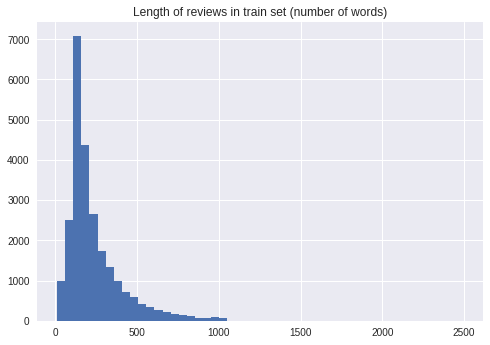

In [9]:
length_reviews = np.array([len(review)-1 for review in train_data])

plt.hist(length_reviews, bins = 50)
plt.title("Length of reviews in train set (number of words)")
plt.show()

In [10]:
print('On average, there are %i words in negative reviews' % np.mean(length_reviews[train_labels ==0]))
print('On average, there are %i words in positive reviews' % np.mean(length_reviews[train_labels ==1]))

On average, there are 234 words in negative reviews
On average, there are 240 words in positive reviews


As we could have expected, positive reviews tend to be a little longer. More generally, we can see from the histogram that the vast majority of reviews contain less than 1000 words. 

Now that we are all set, let's go!

## 3. Preparing the bag of words

Bag of words (BoW) is the most essential feature in Natural Language Processing. Basically, it works like dissembling a Lego castle: you throw all the bricks in a box, and once everything is in the box, you don't care about which brick was where anymore. Same goes for bags of words, where all words are thrown into a bag without remembering where each word was located in the sentence. Then, we vectorize each bag of words (in our case, each review) by associating a frequency to each word. Good reviews will have larger frequencies for words like "great", bad reviews will have larger frequencies for words like "disappointing" etc.

Before using the BoW, we need to make sure however each word is a uniform unit. Let us quickly go through a couple of text processing techniques for this purpose. 

### Length of the reviews

As we've seen from the data exploration part, some reviews are really long and we probably do not need to analyse thousands of words to figure out what the sentiment of a review is. Let us cap the number of words we allow our reviews to have so that it gets easier to process the data (and more reasonable).

In [0]:
cap = 500
train_reviews = np.array([review[0:min(len(review),cap)] for review in train_reviews])
test_reviews = np.array([review[0:min(len(review),cap)] for review in test_reviews])

### Words format

Easy! Keras has done everything for us already: the data is all lowercase, there are  no punctuation signs... Who could ask for more? Now, there are still numbers (like years etc) that we would like to remove because we don't want years to play a role in our analysis, but purely words.

In [0]:
def remove_numeric(review):
  return [word for word in review if word.isalpha()]

In [0]:
train_reviews = np.array([remove_numeric(review) for review in train_reviews])
test_reviews = np.array([remove_numeric(review) for review in test_reviews])

### Stopwords

Stopwords are words we decide to eliminate from the bag of words because we decide they are not relevant. First, let us eliminate the four words we introduced in the Data Processing step. Then, we can also add english stopwords ("he", "be", "i" etc). This step does not necessarily help, so we'll try with and without later on. 

In [0]:
stopwords_keras = ['<PAD>','<START>','<UNK>','<UNUSED>']
stopwords_english = stopwords.words('english')

In [0]:
def remove_stopwords(review):
  return [word for word in review if review not in stopwords_keras]

In [0]:
train_reviews = np.array([remove_stopwords(review) for review in train_reviews])
test_reviews = np.array([remove_stopwords(review) for review in test_reviews])

### Stemming

Stemming... Stemming is a really nice idea. Shouldn't "loving" and "love" be considered as the same word because they convey the same meaning? Stemmers aim to remove grammatical suffixes and reduce words to their roots. There are several stemming algorithms out there. The SnowballStemmer from nltk is widely used, but you might prefer other algorithms. 

However sensible this may sound, using stemming does not always improve model performance that significantly. We'll see for ourselves if this adds anything for our project!

In [17]:
stemmer = SnowballStemmer("english")
print(stemmer.stem('loving'))

love


In [0]:
def stemming(review):
  return [stemmer.stem(word) for word in review]

In [0]:
train_reviews_stemmed = np.array([stemming(review) for review in train_reviews])
test_reviews_stemmed = np.array([stemming(review) for review in test_reviews])

train_reviews = np.array([' '.join(review) for review in train_reviews])
test_reviews = np.array([' '.join(review) for review in test_reviews])
train_reviews_stemmed = np.array([' '.join(review) for review in train_reviews_stemmed])
test_reviews_stemmed = np.array([' '.join(review) for review in test_reviews_stemmed])

## 4. Classification with the Logistic Regression

Now that we have preprocessed the review data, we are ready to start with the modeling part. In this project, we will use the Logistic Regression for this. We will follow a two step approach:

- First, we need to convert our Bag of Words to a vectorized form. Intuitively, it is like assigning frequencies to each word of our sentences and putting them together in one long (very long) vector. Here, instead of just computing a word count, we will use the celebrated Tf-idf vectorizer, which also takes into account how often a word appears in other reviews. 

- Once this is done, these vectorized versions of the reviews are pushed to our Logistic Regression model. 

To optimize the performance of our model, we will gridsearch the best parameters:

- For the Tf-idf vectorization

  - n_gram_range: on how many successive words the vectorization is being performed - what size of ngrams we allow
  - min_df: in how many documents at least can each word ngram appear
  - max_df: in how many documents at most can each word can appear
  - stop_words: whether we use the stopword list we defined above
 
 
 - For the Logistic Regression
 
  - C: how strong the regularization of the logistic regression should be


These two steps are put together in a sklearn pipeline. We will train this pipeline on the non-stemmed data first and run the gridsearch on this dataset.

In [0]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(solver = 'lbfgs'), memory = "cache_folder")
param_grid = {"tfidfvectorizer__ngram_range" : [(1,1),(1,2),(1,3)], 
              "tfidfvectorizer__min_df" : [0.025,0.05],
              "tfidfvectorizer__max_df" : [0.9,0.8],
              "tfidfvectorizer__stop_words" : [None, stopwords_english],
              "logisticregression__C" : [0.1,1]}

### Non-stemmed reviews

In [21]:
grid = GridSearchCV(pipe, param_grid, scoring = 'accuracy', cv = 3, return_train_score = False)
grid.fit(train_reviews, train_labels)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory='cache_folder',
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidfvectorizer__min_df': [0.025, 0.05], 'tfidfvectorizer__max_df': [0.9, 0.8], 'tfidfvectorizer__stop_words': [None, ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'yo...n't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]], 'logisticregression__C': [0.1, 1]},
       pre_dispatch='2*n_jo

In [22]:
best_score_non_stemmed = grid.best_score_
print("The logistic regression achieves a %0.2f accuracy on the validation set" % best_score_non_stemmed)

The logistic regression achieves a 0.85 accuracy on the validation set


Our logistic regression achieved 85% accuracy on the validation set, which is good given that this is using only a linear model!
It is achieved for the following parameters:

In [23]:
best_params_non_stemmed = grid.best_params_
pd.DataFrame({"parameter": list(best_params_non_stemmed.keys()), "best value": list(best_params_non_stemmed.values())})[["parameter","best value"]]

,parameter,best value
0,logisticregression__C,1
1,tfidfvectorizer__max_df,0.9
2,tfidfvectorizer__min_df,0.025
3,tfidfvectorizer__ngram_range,"(1, 2)"
4,tfidfvectorizer__stop_words,None


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


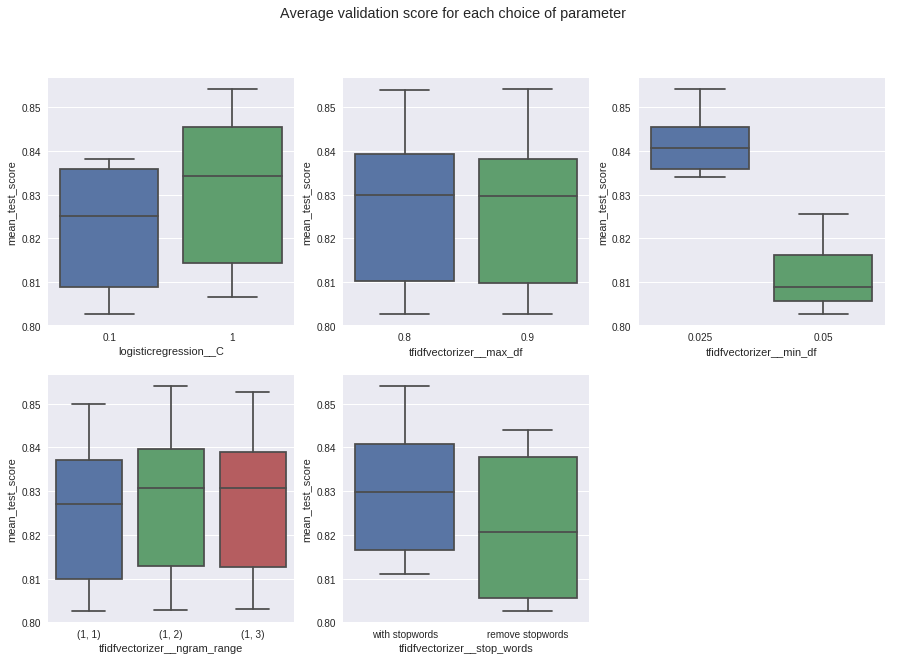

In [24]:
grid_results = pd.DataFrame(grid.cv_results_)
grid_results["param_tfidfvectorizer__stop_words"] = grid_results["param_tfidfvectorizer__stop_words"].apply(
    lambda x : "remove stopwords" if x else "with stopwords")
parameter_names = ["param_logisticregression__C", "param_tfidfvectorizer__max_df", "param_tfidfvectorizer__min_df",
                  "param_tfidfvectorizer__ngram_range", "param_tfidfvectorizer__stop_words"]

fig, axes = plt.subplots(2,3, figsize = (15,10))
axes_list = axes.ravel()
axes[-1, -1].axis('off')
fig.suptitle("Average validation score for each choice of parameter")
for i in range(5):
    sns.boxplot(x=parameter_names[i], y="mean_test_score", data=grid_results, ax = axes_list[i])
    axes_list[i].set_xlabel(parameter_names[i].split("_",1)[1])

The results of the gridsearch highlighted in these boxplots allow us to draw the following conclusions:

- The logistic regression works best with less regularization. In other words, it is beneficial to assign weights to a large number of words
- Ignoring words appearing with a low frequency in the reviews results in much poorer prediction accuracy
- On the other hand, removing words that appear with a very high frequency in the reviews does not impact our prediction accuracy
- Adding bigrams to the word vectorization improves the model, but increasing it further to trigrams does not
- Removing stopwords impacts prediction accuracy negatively

In [0]:
pipe_best = make_pipeline(TfidfVectorizer(ngram_range = best_params_non_stemmed['tfidfvectorizer__ngram_range'],
                                         max_df = best_params_non_stemmed['tfidfvectorizer__max_df'],
                                         min_df = best_params_non_stemmed['tfidfvectorizer__min_df'],
                                         stop_words = best_params_non_stemmed['tfidfvectorizer__stop_words']), 
                          LogisticRegression(solver = 'lbfgs', C = best_params_non_stemmed['logisticregression__C']), memory = "cache_folder")

### Stemmed reviews

Now, let us use the stemmed reviews. As mentioned above, it usually gives a small boost to Natural Language Processing. However, we will not go through the gridsearch process again for the stemmed reviews here. Of course, it can be done, but it is likely to bring little value for a lot of computational time (running the gridsearch above takes some time!). Instead, let us just compare how the best model identified above works.

In [0]:
cross_val_stemmed = cross_validate(pipe_best, train_reviews_stemmed, train_labels, scoring = 'accuracy', cv = 3, return_train_score = False)

In [27]:
cross_val_stemmed_score = np.mean(cross_val_stemmed['test_score'])
print("Using stemming for the reviews, we now have a validation accuracy score of %0.2f" %cross_val_stemmed_score)

if cross_val_stemmed_score>best_score_non_stemmed:
  print("Stemming has increased our prediction accuracy!")
else:
  print("Stemming has decreased our prediction accuracy!")


Using stemming for the reviews, we now have a validation accuracy score of 0.86
Stemming has increased our prediction accuracy!


As expected, stemming does increase our validation score a little, but the improvement is not that substantial either.

Now, at this stage, we have finished building the model. We have found the parameters to use for the vectorization of our reviews, that it is better not to use stopwords, to use stemming, and that it is better not to use any regularization on the logistic regression.

## 5. Evaluating the results

### Weights of the logistic regression

The reason why Logistic Regression is such a nice tool for NLP problems is that you can quantify how much each word contributes to a negative or a positive sentiment. This is done thanks to the weights that get assigned to each of the words after the vectorization. Let us look at it on the non-stemmed dataset, as it is slightly more readable!

In [0]:
vect = TfidfVectorizer(ngram_range = best_params_non_stemmed['tfidfvectorizer__ngram_range'],
                                         max_df = best_params_non_stemmed['tfidfvectorizer__max_df'],
                                         min_df = best_params_non_stemmed['tfidfvectorizer__min_df'],
                                         stop_words = best_params_non_stemmed['tfidfvectorizer__stop_words'])
vect_train_reviews = vect.fit_transform(train_reviews)
feature_names = vect.get_feature_names()

lr = LogisticRegression(solver = "lbfgs", 
                        C = best_params_non_stemmed['logisticregression__C']).fit(vect_train_reviews, train_labels)

Text(0.5, 1.0, 'Top 20 most and less significant words in the IMDB reviews')

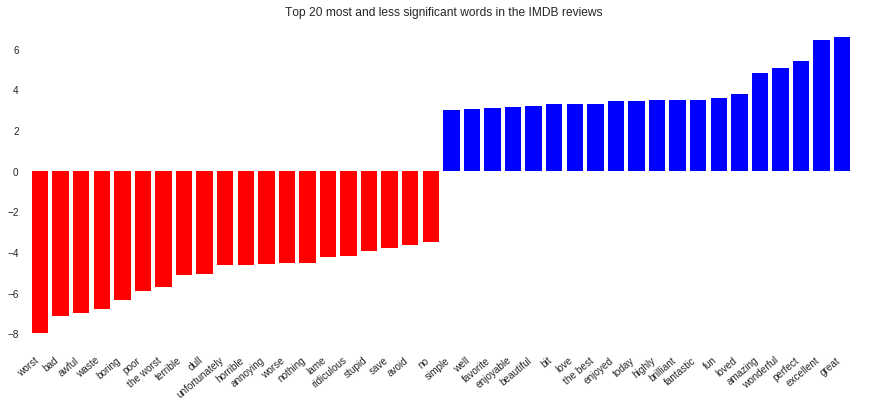

In [29]:
#All credits for this plot go to Prof A. Mueller, who teaches Applied Machine Learning at Columbia University
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=40):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

    
plt.figure(figsize=(15, 6))
plot_important_features(lr.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
plt.title("Top 20 most and less significant words in the IMDB reviews")

All of this makes a lot of sense! Note that the vast majority of these words are unigrams, with the exception of "the worst" and "the best". This shows that the benefits of using bigrams is quite limited and that using a straightforward review vectorization could have worked just as well too.

Before wrapping it up, let us discuss the main downfall of this model (because yes, it has some...). Here are two reviews:

In [30]:
pipe_best.fit(train_reviews_stemmed, train_labels)

Pipeline(memory='cache_folder',
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.025,
        ngram_range=(1, 2), norm='l2', preprocessor=None, sm...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [0]:
reviews = ["i loved this movie it was amazing",
           "this movie was not good at all"]

The first is straightforward. But the second expresses the opposite by a negation. As a result, there is still the word "good" in it, and our model is not great at understanding how "not" impacts "good" to reverse its meaning. Hence, the first review gets correctly labeled as positive with a probability of 97%, whereas the second review gets labeled as negative with only 51% probability.

In [32]:
pipe_best.predict_proba(stemming(reviews))

array([[0.02691319, 0.97308681],
       [0.51140313, 0.48859687]])

This illustrates that our model is only looking at word blocks, but is not able to retrieve any semantic from the syntax of the reviews. It is the main downside of this model.

### Testing the model

In the previous steps, we have evaluated our model using cross validation. This has allowed to identify what modeling steps yielded the best results. Now, let us see how our model performs with reviews from the test set.

In [33]:
test_score = accuracy_score(test_labels, pipe_best.predict(test_reviews_stemmed))
print("Our classifier has an accuracy of %0.2f on the test set" % test_score)

Our classifier has an accuracy of 0.87 on the test set


This is really good isn't it? Just for fun, let us try out our model on two more Hitchcock reviews found online (both are very positive reviews)

a) A review of Notorious (Alfred Hitchcock, 1946) by From Frank Cottrell Boyce, The Guardian 2012 (<a href = "https://www.theguardian.com/film/2012/jun/17/my-favourite-hitchcock-film-notorious-frank-cottrell-boyce">full review here</a>)

"Notorious is perfect. Everyone knows that. It's a testament to Ben Hecht's complex, headlong script that so many people have tried to rip it off and a testament to Hitchcock's genius that no one has ever succeeded. Take a look at the gabby, inconsequential, forgotten Mission Impossible: II and you'll see what I mean. The more obvious glories of Notorious include a revelatory performance from Cary Grant as the morally exhausted American agent Devlin, a terrifying Nazi-mother super-villain played by Leopoldine Konstantin and cinema's most cunningly prolonged kiss."

b) A review of Vertigo (Alfred Hitchcock, 1958) by Peter Bradshaw, The Guardian 2018 (<a href = "https://www.theguardian.com/film/2018/jul/12/vertigo-review-alfred-hitchcock-james-stewart-kim-novak">full review here</a>)

"When I watched this again, I felt more strongly than ever that Hitchcock’s decision to give us a story in which the Clouzot-esque twist is given away well before the end is no misjudgment. It is a brilliant way of putting us inside Judy’s tormented, guilty soul, and of avoiding, just for a while, that male gaze. I also realised what it is Vertigo has been subtly reminding me of for many years: Graham Greene’s The End of the Affair. A treat to see this back on the big screen."


In [0]:
notorious_review = "Notorious is perfect. Everyone knows that. It's a testament to Ben Hecht's complex, headlong script that so many people have tried to rip it off and a testament to Hitchcock's genius that no one has ever succeeded. Take a look at the gabby, inconsequential, forgotten Mission Impossible: II and you'll see what I mean. The more obvious glories of Notorious include a revelatory performance from Cary Grant as the morally exhausted American agent Devlin, a terrifying Nazi-mother super-villain played by Leopoldine Konstantin and cinema's most cunningly prolonged kiss."
vertigo_review = "When I watched this again, I felt more strongly than ever that Hitchcock’s decision to give us a story in which the Clouzot-esque twist is given away well before the end is no misjudgment. It is a brilliant way of putting us inside Judy’s tormented, guilty soul, and of avoiding, just for a while, that male gaze. I also realised what it is Vertigo has been subtly reminding me of for many years: Graham Greene’s The End of the Affair. A treat to see this back on the big screen."

In [0]:
hitchcock_reviews = [notorious_review, vertigo_review]
hitchcock_reviews = [''.join(ch for ch in review.lower() if ch not in string.punctuation) for review in hitchcock_reviews]

In [36]:
pipe_best.predict_proba(stemming(hitchcock_reviews))

array([[0.29270778, 0.70729222],
       [0.0750691 , 0.9249309 ]])

The Notorious review is labeled as positive with 71%, the Vertigo review gets labeled as positive with 92% probability. 

## 6. Conclusion

In this post, we have gone through some of the most widely used Natural Language Processing techniques and trained a linear model to classify movie reviews. There are more fancy ways of doing this, and we will cover other techniques soon, but topics covered in this project are solid basics to start with and relatively easy to achieve.

We achieved a 87% test accuracy. Even though there are some downfalls that we addressed, it is along the lines of what is usually achieved in other ML sources with a linear model.